In [1]:
from itertools import cycle
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib
import warnings
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
plt.style.use('seaborn-ticks')
# sns.set_style("ticks")
rcParams['font.family']='sans-serif'
rcParams['font.sans-serif'] = ['Microsoft YaHei'] #指定默认字体为细黑
rcParams['axes.unicode_minus'] = False # 解决负号显示问题
plt.rc('font', size=20) #设置字体大小
plt.rc('lines', linewidth=2) #设置线条宽度
warnings.filterwarnings('ignore')

In [2]:
# 定义mem_reducer函数读取数据，节省内存
strings = 'str'
ints = ['int8', 'int16', 'int32', 'int64']
floats = ['float16', 'float32', 'float64']

def mem_reducer(data):

    for col in data.columns:
        col_type = data[col].dtypes

        if col_type in (ints + floats):
            col_min = data[col].min()
            col_max = data[col].max()

            if col_type in ints:

                    if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                        data[col] = data[col].astype(np.int8)

                    elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                        data[col] = data[col].astype(np.int16)

                    elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                        data[col] = data[col].astype(np.int32)

                    elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                        data[col] = data[col].astype(np.int64)


            if col_type in floats:

                    if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                        data[col] = data[col].astype(np.float16)

                    elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                        data[col] = data[col].astype(np.float32)

                    elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                        data[col] = data[col].astype(np.float64)

        else:
            pass

    return data


# 数据读取与存储

**查看数据文件**

In [5]:
files = [file for file in os.listdir() if '.csv' in file]
cal, ste, stv, ss, sp = len(files)*[pd.DataFrame()]
ls_temp = [cal, ste, stv, ss, sp]

for i in range(len(files)):
    data = pd.read_csv(files[i])
    start_mem = data.memory_usage().sum() # 返回以字节为单位的每列占用内存之和
    print(f'\n读取{files[i]}\n')
    ls_temp[i] = mem_reducer(data)
    end_mem = ls_temp[i].memory_usage().sum()
    mem_saved = (start_mem - end_mem)/start_mem # 计算内存节约比率
    print(f"\t读取完毕，节省内存：{mem_saved*100} %")
    ls_temp[i].to_hdf(files[i][:-4]+'.h5', key='df', mode='w')
    print(f'\t已将数据写入hdf文件')


读取calendar.csv

	读取完毕，节省内存：41.93994271626423 %
	已将数据写入hdf文件

读取sales_train_evaluation.csv

	读取完毕，节省内存：78.77501728908437 %
	已将数据写入hdf文件

读取sales_train_validation.csv

	读取完毕，节省内存：78.7193635701158 %
	已将数据写入hdf文件

读取sample_submission.csv

	读取完毕，节省内存：84.48199425933424 %
	已将数据写入hdf文件

读取sell_prices.csv

	读取完毕，节省内存：37.499978073781726 %
	已将数据写入hdf文件


In [4]:
# 转换类型
cal.wm_yr_wk = cal.wm_yr_wk.astype('int16')
cal.date = pd.to_datetime(cal.date, format='%Y-%m-%d')
cal_train = cal[:1913]

In [5]:
#  自定义风格
# 淡化边缘
def plotDecorator(ax):
    ax.spines["top"].set_alpha(.3)
    ax.spines["bottom"].set_alpha(.3)
    ax.spines["right"].set_alpha(.3)
    ax.spines["left"].set_alpha(.3)

**变量汇总**

| 变量          | 含义                                                         | 所在位置 |
| :------------ | ------------------------------------------------------------ | :------- |
| id            | 每个商品的专属id，由它所属的分类（category），部门（department），编号（item_id），所属门店（store_id）和门店所在的州（state）组合构成。 | stv      |
| d_xxxx        | 日期标识，代表从2011年1月29日开始到2016年4月24日的第n天的商品销量，如d_2对应的是2011年1月30日的商品销量。st | stv, cal |
| wm_yr_wk      | Walmart日历，wm是Walmart的缩写，yr是year的缩写，代表财年，wk是week的缩写，代表周。如，2016-04-20对应的wm_yr_wk为11612，代表2016-04-20处于2016财年的第12个周。 | sp, cal  |
| sell_price    | 商品的售价，一个售价的有效期为一个Walmart周。                | sp       |
| event_name_x  | 活动（如节假日）等的名称。包括Christmas，Thanksgiving和ValentinesDay等31种活动类型。 | cal      |
| event_type_x  | 活动的类型，包括Cultural, National, Religious和Sporting共4种。 | cal      |
| snap_x        | 某州（state）是否加入美国政府补助的健康饮食计划。            | cal      |
| weekday, wday | weekday代表公历的星期日期，wday代表Walmart制定的每个星期日期对应的序号，如每周的第1个wday对应的是星期六。 | cal      |


**查看几张表格的表头**

In [11]:
print(f'行数：{stv.shape[0]}, 列数{stv.shape[1]}')
stv.head()

行数：30490, 列数1919


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [12]:
print(f'行数：{cal.shape[0]}, 列数{cal.shape[1]}')
cal.head()

行数：1969, 列数14


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,nan,nan,nan,nan,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,nan,nan,nan,nan,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,nan,nan,nan,nan,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,nan,nan,nan,nan,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,nan,nan,nan,nan,1,0,1


<br> <br>
**交叉查询dept_id和store_id。**
<br> <br>
由下表可知，30490种商品可分为3类：'HOBBIES'，'HOUSEHOLD'和'FOODS'3类。其中HOBBIES有2个部门，HOUSEHOLD有2个部门，FOODS有三个部门。在3个分类中，**FOODS类的商品种类最多，HOBBIES类的商品种类最少**。而在8个部门中，**FOODS_3的商品种类最多，HOBBIES_2的种类最少**。所有商品在3个州有售，分别是CA，TX和WI，这些州分别拥有4个，3个和3个门店。同时我们可以看到**10家门店在售的商品完全相同**，并不存在某些商品只在特定门店销售的情况。这有利于我们对同一商品在不同门店的销售情况进行横向对比。


In [6]:
store_dept_cross = pd.crosstab(stv['store_id'], stv['dept_id'], margins=True)
store_dept_cross

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,All
store_id,,,,,,,,
CA_1,216,398,823,416,149,532,515,3049
CA_2,216,398,823,416,149,532,515,3049
CA_3,216,398,823,416,149,532,515,3049
CA_4,216,398,823,416,149,532,515,3049
TX_1,216,398,823,416,149,532,515,3049
TX_2,216,398,823,416,149,532,515,3049
TX_3,216,398,823,416,149,532,515,3049
WI_1,216,398,823,416,149,532,515,3049
WI_2,216,398,823,416,149,532,515,3049


由于所有的商品并不是在同时上架的，在样本时间范围内，在售的商品种类增加可能会导致商品总销量的增加。但本次竞赛是以个体商品的销量为预测目标，因此为了更准确地看到商品销量随时间的变化，我们需要对商品的在售时间进行修正，修正的依据是商品的售价。

In [16]:

# 设置index
dateindex = cal_train.date
# 选择需要的列名
d_cols = [col for col in stv.columns if 'd_' in col]
groups = sp.groupby(['wm_yr_wk'])
marked = stv[d_cols].copy()
marked.index = stv.id
prices = pd.DataFrame(index=marked.index, columns=d_cols)

In [17]:
# 定义替换函数
def repzero(df):
    # 筛选商品在售的wm_yr_wk日期
    dates = cal_train.d[cal_train.wm_yr_wk==df.name]
    # 获得日期内的商品id
    df.id = df.item_id + '_' + df.store_id + '_validation'
    # 获得不在售的商品id
    nullitems = stv.id[~stv.id.isin(df.id)]
    # 将不在售商品的销量替换为np.nan
    marked.loc[nullitems, dates] = np.nan
    # 将价格信息填入prices DataFrame
    price = np.tile(df.sell_price.values, (len(dates), 1)).T
    prices.loc[df.id, dates] = price

start = time.time() # 计算运行时间
groups.apply(repzero)# 用apply加快运行速度
end = time.time()
print(end - start)

122.74047446250916


**累计销量：** 图1显示日累计销量呈上升趋势，但并不代表单个商品的销量也有上升的趋势，商品总类的增加也可能造成累计销量的增加。因此我们需要进一步观察日累计商品种类。由于存在某些商品在某个时间段内没有进行销售的情况，我们需要借助价格信息来判断某商品是否在该日进行销售。**图-2显示，商品种类整体呈明显的上升趋势。在2011到2012年左右，商品种类的增速较快，因此而图-3中单件商品日均销量有明显下降的趋势。2012年以后商品种类的增速主渐放缓，到2015年开始逐渐趋于稳定，而单件商品的日均销量也逐渐趋于稳定。** 以上结果表明，整体销量的增长并不能很好地反映单个商品销量的趋势变化， 因此不考虑将它作为特征变量。

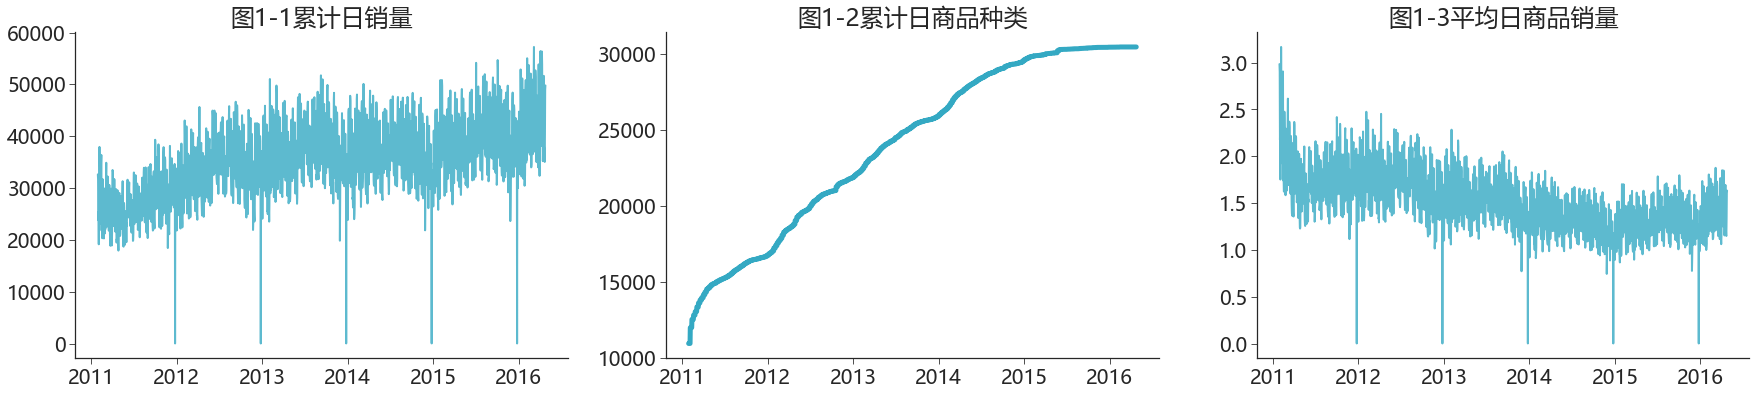

In [213]:
# 累计日销量统计
day_agg_sales, day_agg_items, day_mean_sales = marked.sum(), marked.count(), marked.mean()
day_agg_sales.index, day_agg_items.index, day_mean_sales.index = dateindex, dateindex, dateindex
# 作图
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30, 6), gridspec_kw={'width_ratios':[1, 1, 1]})
axes = ax.flatten()
cline = colors[5]
axes[0].plot(day_agg_sales.index, day_agg_sales, color=cline, alpha=0.8)
axes[0].set_title('图1-1累计日销量')
axes[1].plot(day_agg_items.index, day_agg_items, color=cline, linewidth=5)
axes[1].set_title('图1-2累计日商品种类')
axes[2].plot(day_mean_sales.index, day_mean_sales, color=cline, alpha=0.8)
axes[2].set_title('图1-3平均日商品销量')
sns.despine()

**定价策略**：**商品并未同一售价**。
如图4-2所示，以商品FOODS_3_090为例，该商品在11215周就拥有4种不同的定价。

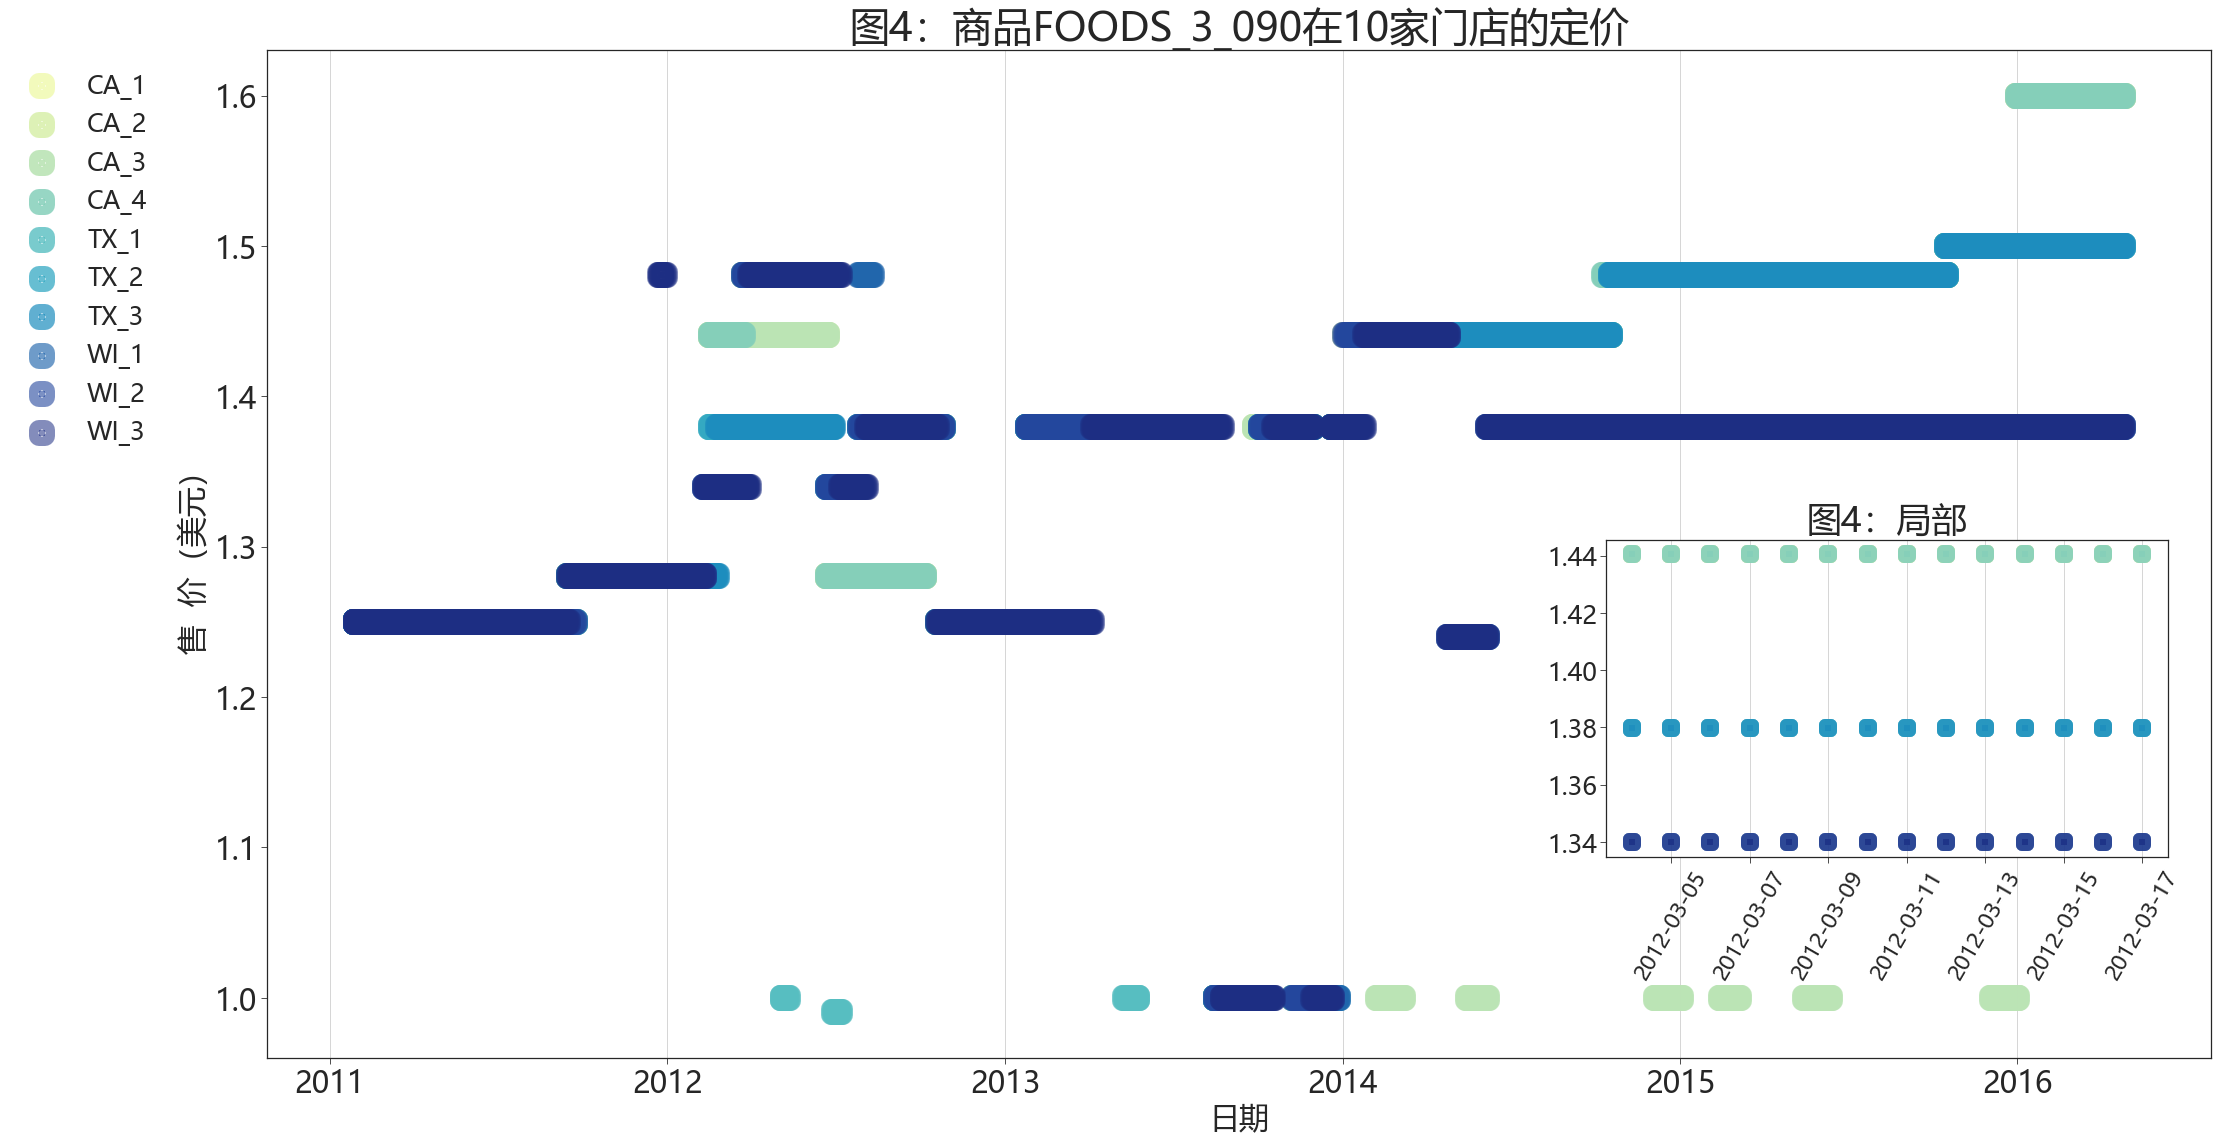

In [248]:
# 分组，切片
prices['item_id'] = stv['item_id'].values
prices['store_id'] = stv['store_id'].values
groups = prices.groupby(['item_id', 'store_id'])
item = 'FOODS_3_090'
stores = store_dept_cross.index
# 设置画布
fig = plt.figure()
plt.xticks(fontsize=20)
ax1 = fig.add_axes([0.0, 0.0, 4.5, 3.5]) # left, bottom, width, height
ax2 = fig.add_axes([3.1, 0.7, 1.3, 1.1])
# 设置颜色
colors = sns.color_palette('YlGnBu', 10) #

# 在画布上绘图
for i in range(0, 10):
    temp = groups.get_group((item, stores[i]))[d_cols].T
    temp.index = dateindex
    ax1.scatter(temp.index, temp, color=colors[i], 
                label=stores[i], linewidth=20, marker='s', alpha=1-0.05*i)
    ax2.scatter(temp.index[400:414], temp[400:414], color=colors[i], 
                label=stores[i], linewidth=12, marker='s', alpha=1-0.05*i)
# 设置大图参数
ax1.set_title(f'图4：商品{item}在10家门店的定价', fontsize=40)
ax1.legend(bbox_to_anchor=(-0.05, 1), fontsize=25)
ax1.set_xlabel('日期', fontsize=30)
ax1.set_ylabel('售  价（美元）', fontsize=30)
ax1.xaxis.set_tick_params(labelsize=30)
ax1.yaxis.set_tick_params(labelsize=30)
ax1.grid(axis='x')
# 设置小图参数
ax2.set_title(f'图4：局部', fontsize=35)
ax2.xaxis.set_tick_params(labelsize=22, rotation=60)
ax2.yaxis.set_tick_params(labelsize=25)
ax2.grid(axis='x')

**定价会影响销量吗** 

以商品FOODS_3_824_WI_3为例，在价格上升时，商品的销量小于调整前的销量（期间有长时间销量为0的情况，可能时库存不足）；而在价格有大幅下降时，销量会出现较大的上升。但随后很长一段时间销量均为0，这样的情况出现可能是因为销量的大幅上升清空了库存，或者商家为了清库存而进行了促销。
从三类商品中各选择一些商品，观察它们的价格和平均销量可发现商品销量并不总随价格的降低而增加。当然异常的原因也可能是大幅的降价优惠导致库存清空，而补货需要的时间较长造成低定价时期的零销量。

Text(0, 0.5, '售价（美元）')

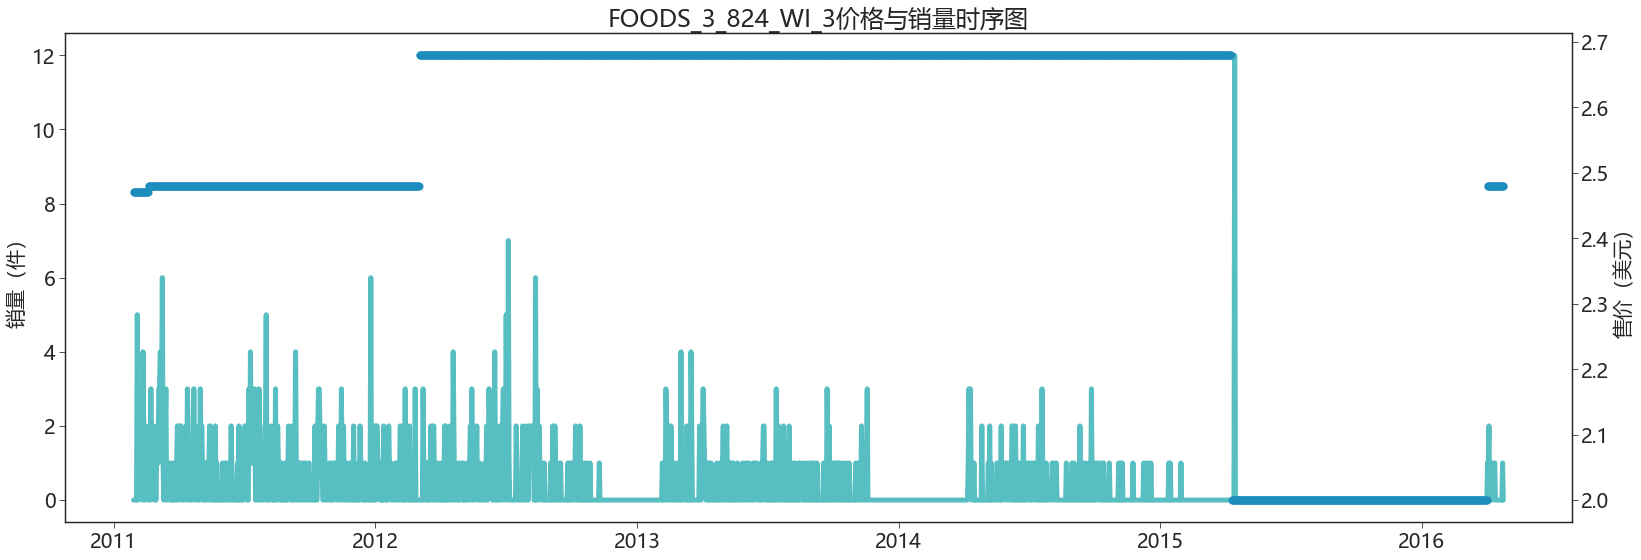

In [428]:
eg_food_p = prices.loc['FOODS_3_824_WI_3_validation'][d_cols]
eg_food_s = marked.loc['FOODS_3_824_WI_3_validation'][d_cols]
eg_food_p.index, eg_food_s.index = dateindex, dateindex
fig, ax1 = plt.subplots(figsize=(27, 9))
ax1.plot(eg_food_s.index, eg_food_s, color=colors[4], linewidth=5)
ax1.set_title('FOODS_3_824_WI_3价格与销量时序图')
ax1.set_ylabel('销量（件）')
ax2 = ax1.twinx()
ax2.scatter(eg_food_p.index, eg_food_p, linewidth=5, color=colors[6], 
            marker='.')
ax2.set_ylabel('售价（美元）')


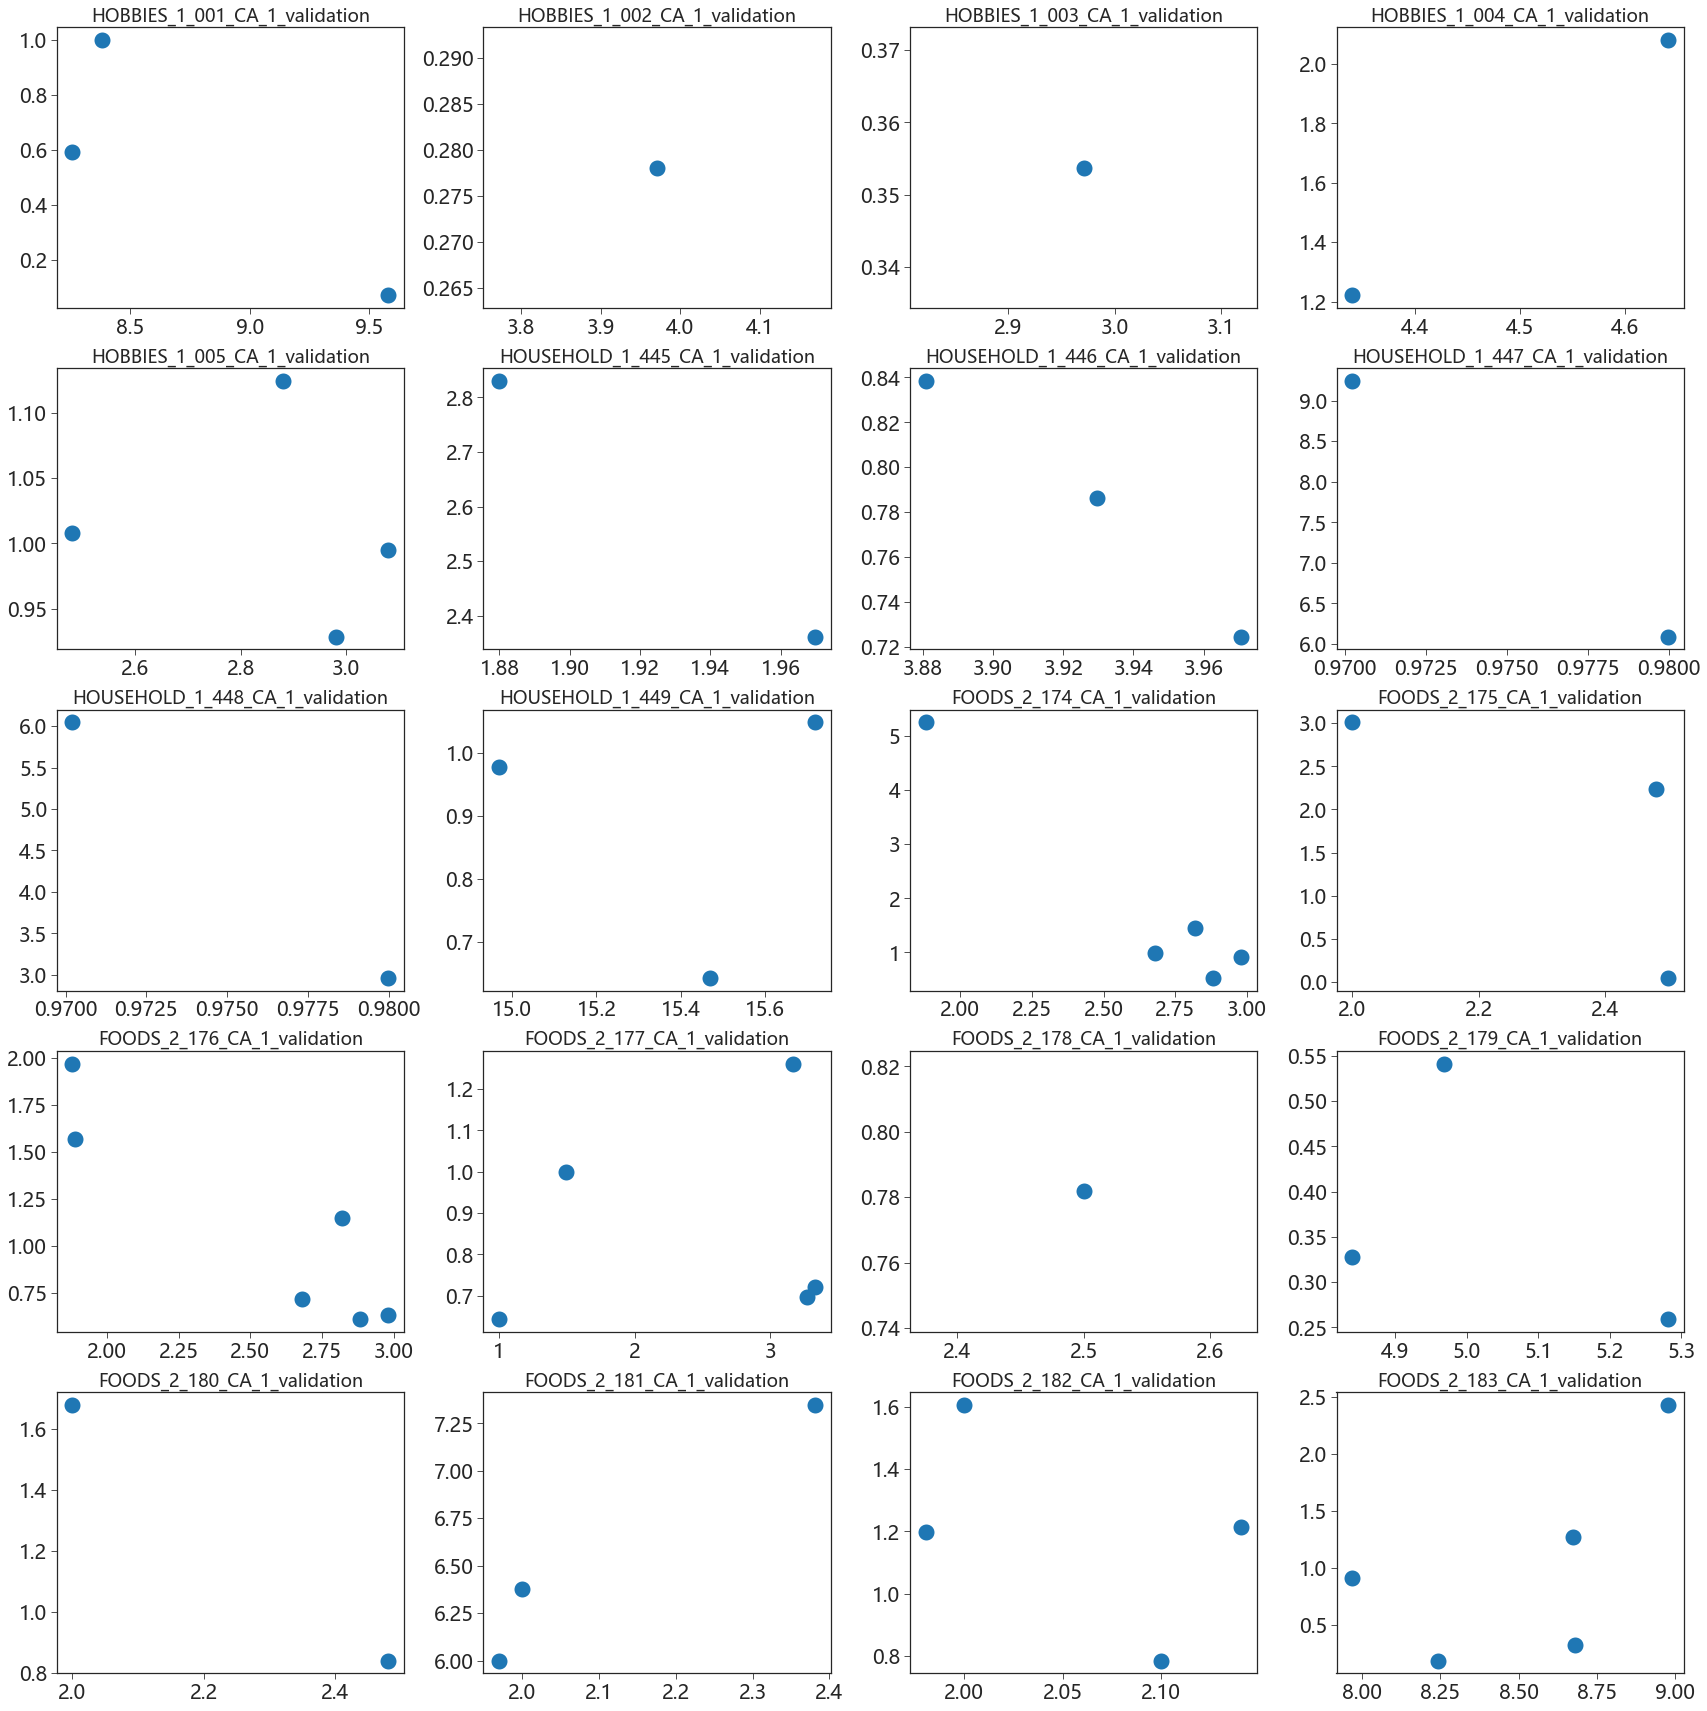

In [371]:
marked[d_cols] = marked[d_cols].astype('float16')
temp = list(marked.index)
items = temp[:5] + temp[1000:1005] + temp[2000:2010]
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(24, 24))
axes = ax.flatten()
plt.tight_layout()
i = 0

for item in items:
    df_prices_sales = pd.concat([prices.loc[item][d_cols], 
                                 marked.loc[item][d_cols]],axis=1)
    df_prices_sales.columns = ['prices', 'sales']
    df_prices_sales['sales'] = df_prices_sales['sales'].astype('float16')
    groups = df_prices_sales.groupby('prices')
    axes[i].scatter(groups.mean().index, groups.mean(), linewidth=10)
    axes[i].set_title(item, fontsize=18)
    i = i + 1

**节假日会影响销量吗**：图1-1中有明显的异常值，并且每年都会出现，此处考虑节假日的影响。节假日会对商店产生不同的影响，比如某些节假日会进行促销活动，导致销量上升；而某些节假日，如11.11老兵日和12.25圣诞节，商店会关门或提前关门，导致销量下降。图3中5处明显的异常值都是每年的12月25日圣诞节，因此销量明显低于平时，此外这是11.11老兵日。可考虑将其剔除出训练集。

Text(2012-12-25 00:00:00, 10011.0, '最低销量：2012-12-25, Christmas')

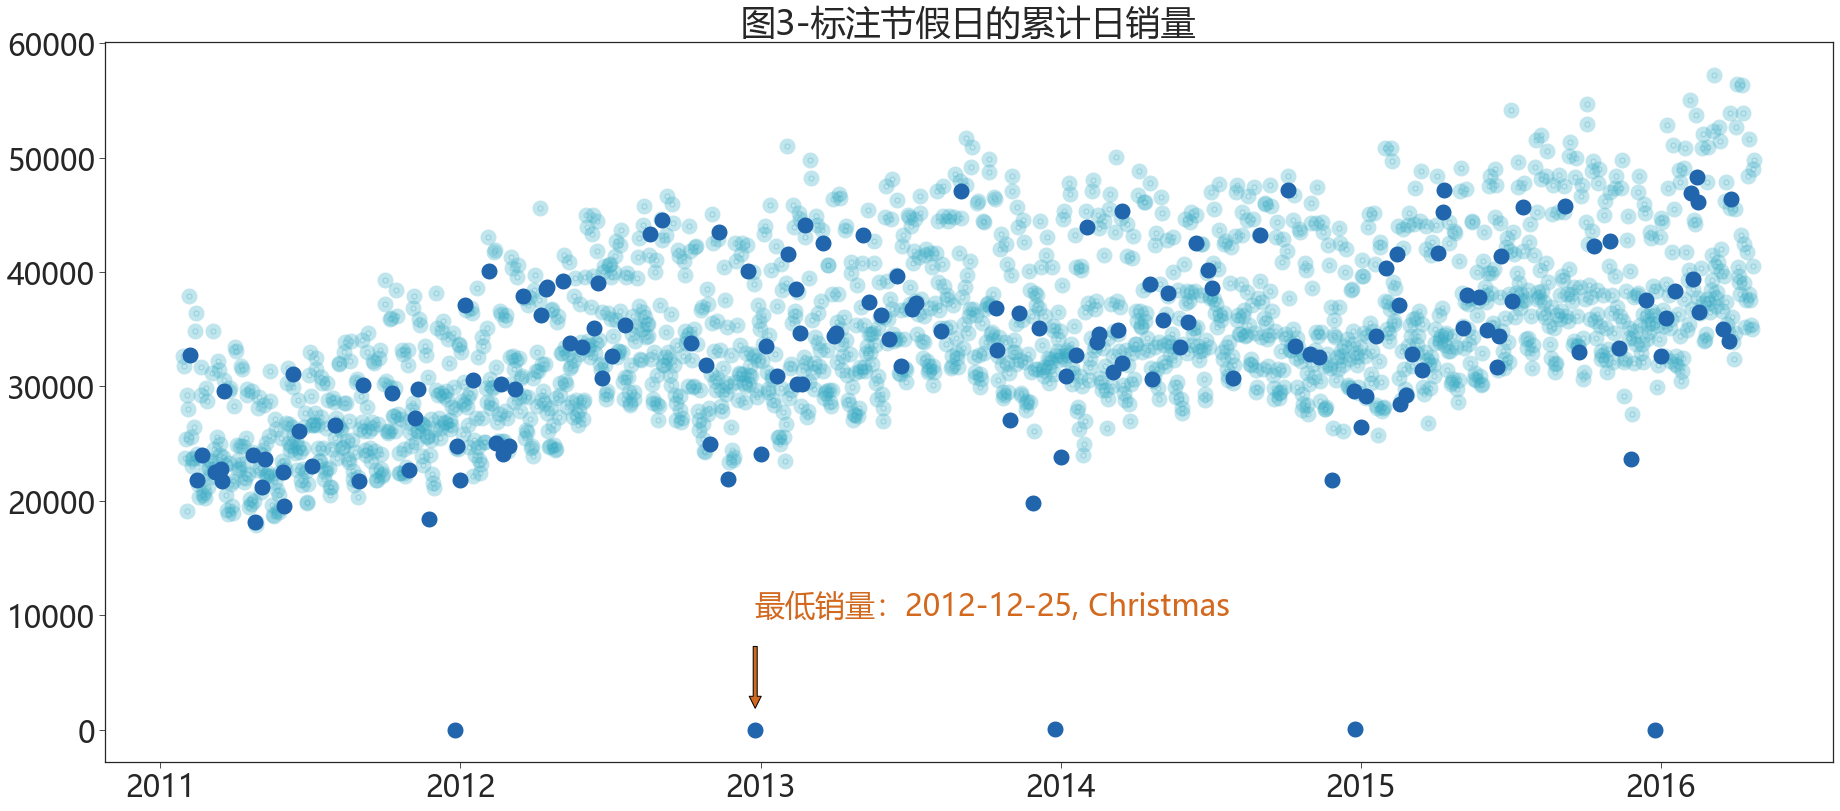

In [214]:
import matplotlib.dates as mdates
evdays = cal_train.date[:1913][cal_train.event_name_1!='nan']
nonevdays = cal_train.date[:1913][cal_train.event_name_1=='nan']
evsales, nonevsales = pd.Series(index=dateindex), pd.Series(index=dateindex)
evsales[evdays] = day_agg_sales[evdays]
nonevsales[nonevdays] = day_agg_sales[nonevdays]
# 设置绘图格式
fig = plt.figure()
ax = fig.add_axes([0, 0, 4, 2.5])
ax.scatter(dateindex, nonevsales, linewidth=10, color=colors[5], alpha=0.3)
ax.scatter(dateindex, evsales, linewidth=10, color=colors[7])
ax.set_title(label='图3-标注节假日的累计日销量', fontsize=35)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
# 获取最小值的索引
min_idx = day_agg_sales.idxmin()
x = pd.Timestamp(min_idx)
y = day_agg_sales.min()
min_loc = dateindex[dateindex==min_idx].index.values[0]
text = '最低销量：' + str(min_idx)[:10] + ', ' + cal_train.event_name_1[min_loc]
ax.annotate(text, xy=(x, y), xytext=(x, y+10000), color='chocolate', 
            size=30, arrowprops=dict(facecolor='chocolate', shrink=0.2))

节假日于非节假日的销量差异并不太大，但总体来说销量水平略低于非节假日销量。同时节假日销量的异常值表现为销量远低于一般最小值，而非节假日的异常值则表现为高于一般最大值。

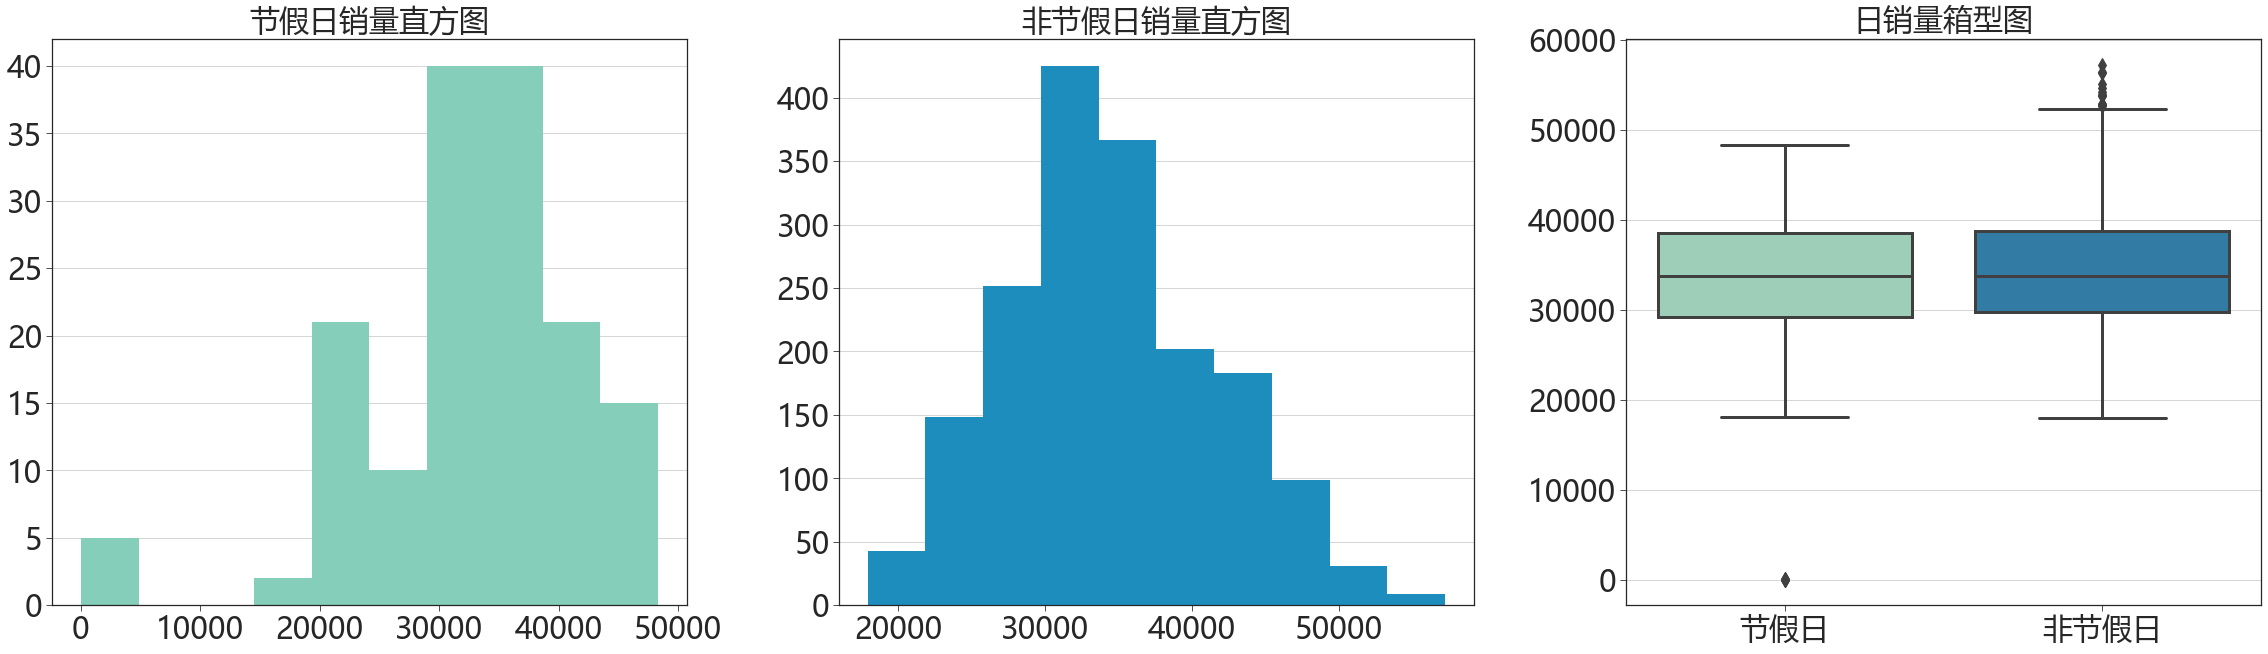

In [248]:
df_ev_nonev_sales = pd.concat([evsales, nonevsales], axis=1)
df_ev_nonev_sales.columns = ['节假日', '非节假日']
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(32, 9), 
                       gridspec_kw={'width_ratios':[2, 2, 2]})
plt.tight_layout(w_pad=5)
axes = ax.flatten()
# 直方图1
axes[0].hist(df_ev_nonev_sales['节假日'], color=colors[3])
axes[0].set_title('节假日销量直方图', fontsize=30)
axes[0].xaxis.set_tick_params(labelsize=30)
axes[0].yaxis.set_tick_params(labelsize=30)
axes[0].grid(axis='y')
# 直方图2
axes[1].hist(df_ev_nonev_sales['非节假日'], color=colors[6])
axes[1].set_title('非节假日销量直方图', fontsize=30)
axes[1].xaxis.set_tick_params(labelsize=30)
axes[1].yaxis.set_tick_params(labelsize=30)
axes[1].grid(axis='y')
# 箱型图
sns.boxplot(data=df_ev_nonev_sales, fliersize=10, linewidth=3, palette='YlGnBu')
axes[2].set_title('日销量箱型图', fontsize=30)
axes[2].xaxis.set_tick_params(labelsize=30)
axes[2].yaxis.set_tick_params(labelsize=30)
axes[2].grid(axis='y')
# df_ev_nonev_sales.hist(bins=50, ax=axes[1])

**季节性存在吗？**

Text(0.5, 1.0, '一周各天的日均销量')

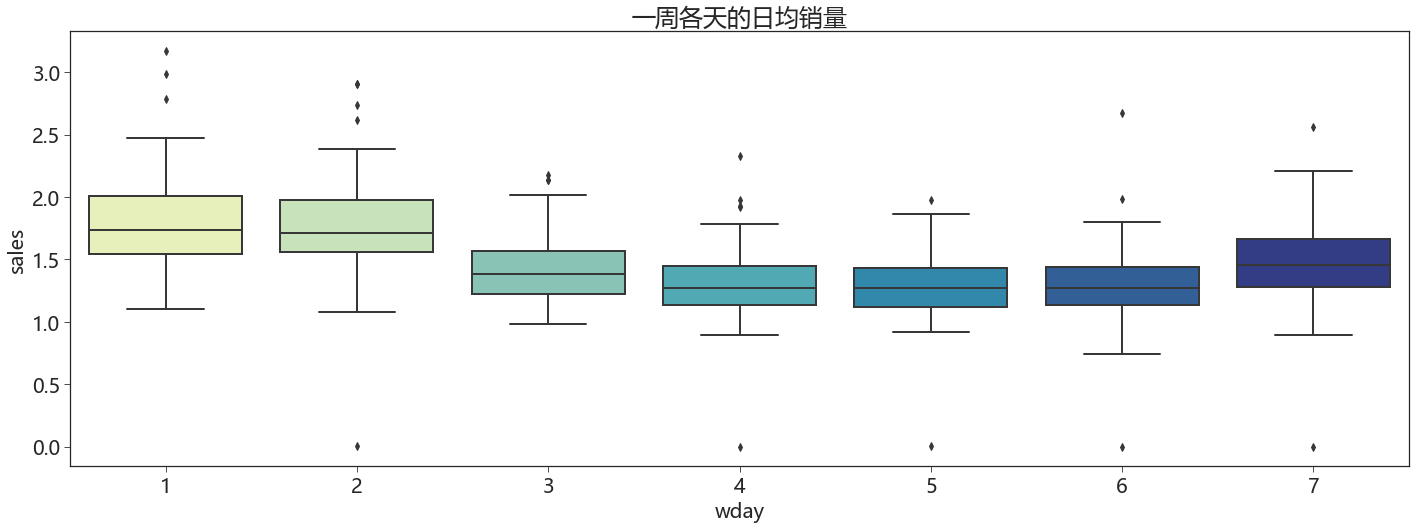

In [220]:
wday = pd.Series(cal_train.wday.values, index=dateindex)
df_day_mean_sales = pd.concat([day_mean_sales, wday], axis=1)
df_day_mean_sales.columns = ['sales', 'wday']
fig, ax = plt.subplots(figsize=(24, 8))
sns.boxplot(data=df_day_mean_sales, x='wday', y='sales', palette='YlGnBu')
ax.set_title(label='一周各天的日均销量')

**不同的门店销量销量会存在显著的差异吗？** 导致不同门店销量差异的因素有：
* 销售商品的种类不同。根据表1的结论，10家门店所售的商品相同，因此我们就可以排除销售的商品种类不同导致的销量上的差异。
* 同一时间不同门店对同一商品的定价不同。由图2可知不同门店在同一时间对于同一商品的定价是存在不同的。但是相对于线上购物，消费者要在各个商店间进行比价的成本较高，可能性也较小，因此定价差异的影响可以忽略。
* 还有一些因素，如同一商品在不同门店的摆放位置，门店所处的地理位置，其服务的范围和其范围内的人群密度，门店的装修风格甚至员工的素质等等均暂不知晓，但这些因素的影响都会反映在历史销量信息中，因此可用历史销量作为这些因素的代理。
\
\
    不难看出各个门店的销量水平存在一定的差异。整体而言，加州3个门店的销量高于其他两个周，但其内部的销量差异也十分巨大，销量第一的加州3号店销量远高于销量最低的加州4号店。相比之下，德州3家门店的销量差异较小，同一门店不同时期的销量差距也较小。威斯康星州3家店虽然销量差异不如加州4家店之大，但是每家门店不同时期的销量差异却较大。

Text(0.5, 1.0, '图5-各门店日销量')

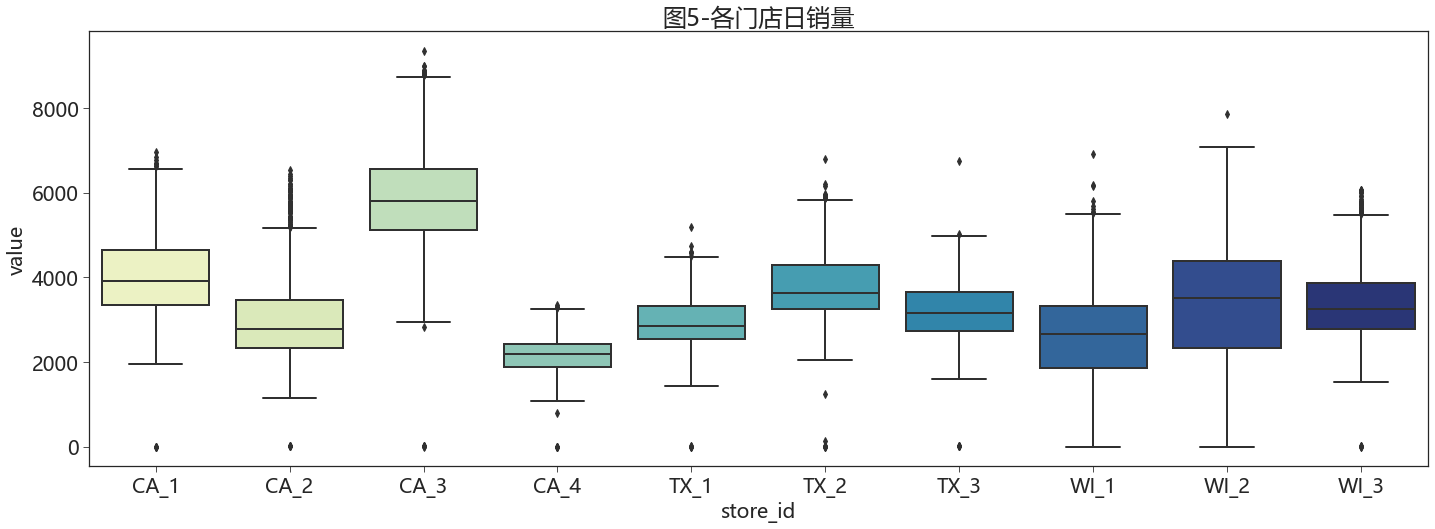

In [221]:
df_store_mean_sales = stv.groupby('store_id').sum()
fig, ax = plt.subplots(figsize=(24, 8))
sns.boxplot(data=pd.melt(df_store_mean_sales.T), x='store_id', 
            y='value', palette='YlGnBu')
ax.set_title('图5-各门店日销量')

**不同类别的商品销量会有差异吗？** 由于每个category中的包含的商品种类不同，为了避免这个因素导致的差异，我们选用平均销量而非总销量。由图6可以看出，在剔除了商品种类的影响后，FOODS类商品的销量仍高于其他两类商品。
三类商品的销量的长期趋势有所不同。FOOS类和HOBBIES类商品的平均销量都在销售初期达到峰值，然后逐渐下降稳定在一定的区间内，而HOUSEHOLD类商品销量在2011年初期经历了一定幅度的下降后，在2012年后期逐步上升并维持在较高水平。整体来看，按照日销量排序：
$$foods > household > hobbies$$
因此考虑将商品销量按商品分类进行预测。同时, 不同类别商品的销量波动也存在差异。由图可得FOODS类商品销量的波动率最大，而HOBBIES类波动率最小。这可能是由于商品本身的性质造成的。如一户家庭可能每天都会购买面包，但不会每天都购买洗衣机。

Text(0.5, 1.0, '图6-2：三类商品日销量')

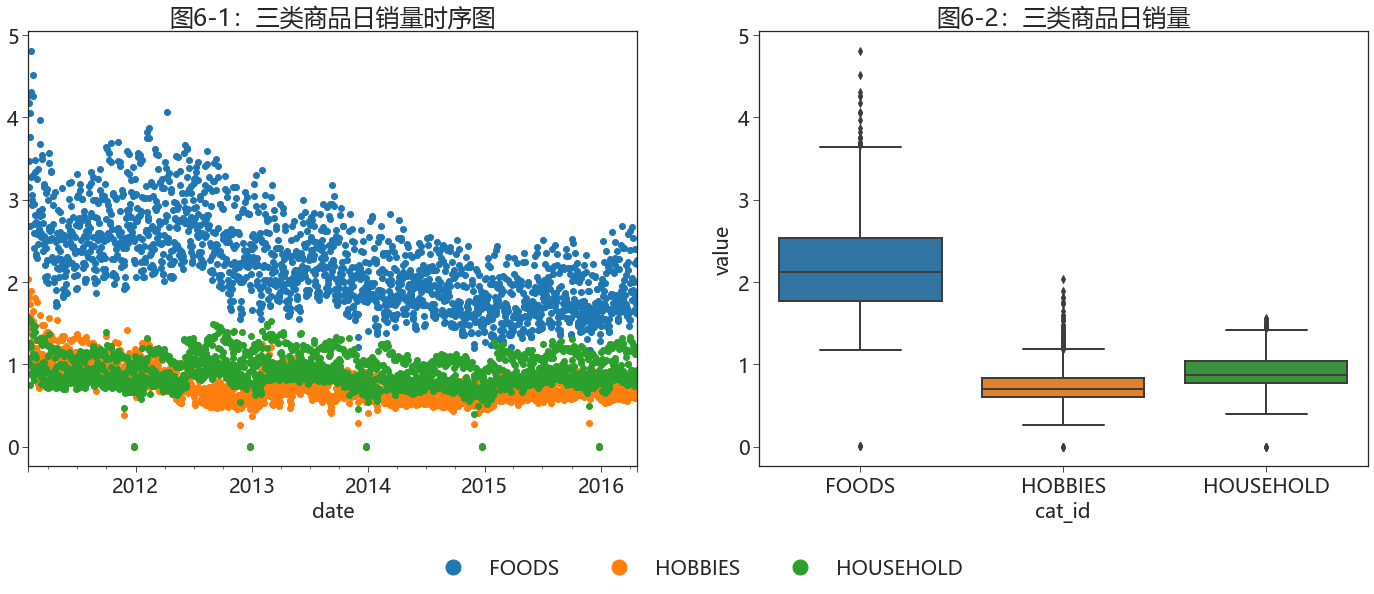

In [77]:
marked['cat_id'] = stv['cat_id'].values
df_cat_mean_sales = marked.groupby('cat_id').mean().T
df_cat_mean_sales.index = dateindex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), 
                       gridspec_kw={'width_ratios':[1, 1]})
axes = ax.flatten()
df_cat_mean_sales.plot(ax=axes[0], style='o')
axes[0].set_title('图6-1：三类商品日销量时序图')
axes[0].legend(loc='lower center', ncol=3, 
               bbox_to_anchor=(1.1, -0.3), markerscale=2.5)
sns.boxplot(data=pd.melt(df_cat_mean_sales), x='cat_id', y='value')
axes[1].set_title('图6-2：三类商品日销量')

**同一个category中不同department的商品销量会有显著差异吗？** 总的来说，同一各category的商品，如果在不同的deparment中，销量水平之间也存在一定的差异。如FOODS类商品，FOODS_3销量明显高于其他两类商品。因此在建模时考虑将dept_id作为特征。

Text(0, 0.5, '日平均销量')

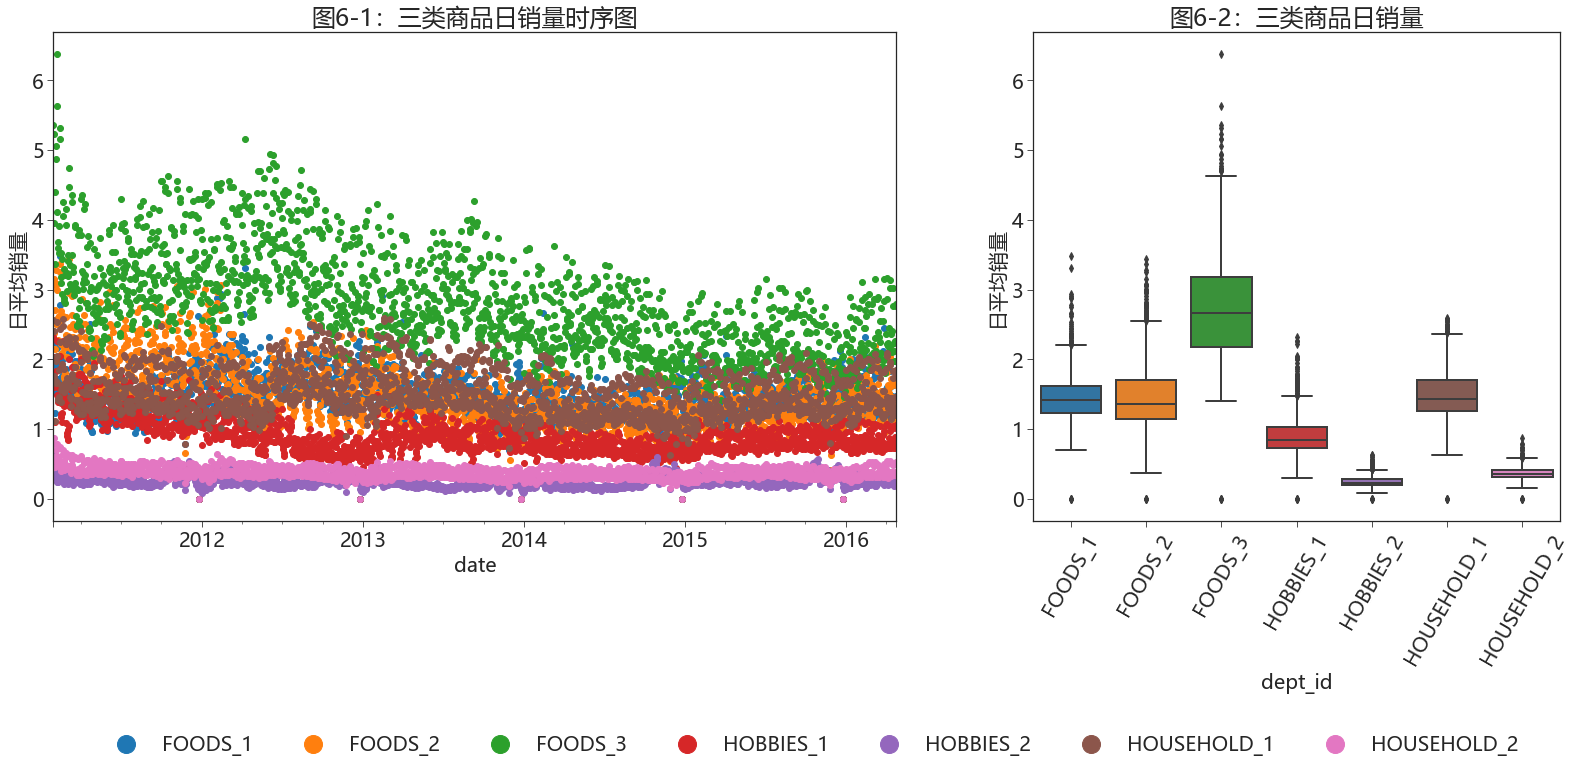

In [434]:
marked['dept_id'] = stv['dept_id'].values
df_cat_mean_sales = marked.groupby('dept_id').mean().T
df_cat_mean_sales.index = dateindex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(27, 9),
                       gridspec_kw={'width_ratios':[1.6, 1]})
axes = ax.flatten()
df_cat_mean_sales.plot(ax=axes[0], style='o')
axes[0].set_title('图6-1：三类商品日销量时序图')
axes[0].legend(loc='upper center', ncol=7, 
               bbox_to_anchor=(0.9, -0.4), markerscale=3)
sns.boxplot(data=pd.melt(df_cat_mean_sales), x='dept_id',
            y='value')
axes[0].set_ylabel('日平均销量')
axes[1].set_title('图6-2：三类商品日销量')
axes[1].xaxis.set_tick_params(rotation=60)
axes[1].set_ylabel('日平均销量')
